[View in Colaboratory](https://colab.research.google.com/github/Indrajeet90/Python-/blob/master/Probability_distribution.ipynb)

**Analyze data**

In [0]:
import pandas as pd
medals_df = pd.read_csv('medals.csv')
# Prune non-data rows
medals_df = medals_df.dropna()

**Plot Medal Count per Year (Norway)**

In [0]:
import matplotlib as plt
%matplotlib inline
nor_medals_year = medals_df[medals_df.NOC == 'NOR'].groupby('Year').size()

**Analysis: Probable Medal Count**   
If it were January 2010, and we had a Norwegian friend that insisted to know the answer to the question, "How many medals do you think Norway will win in this year's olympics?", what should we tell her? What if she asked  the same question in January 1988. Would the same answer be the same?

Looking at the medal count per games for Norway, one can  notice that something changed circa 1992, and Norwegian olympians began to win more medals in every winter olympics since then. We would not likely have given Norway much chance at all to win 20 medals in 1988, but in 2010, the chances that Norway would win 20 medals seems a good bit higher.

**Probability Distribution**    
We will provide our friend with a probability distribution for Norway's medal counts.

Let M be the medal count awarded to a country during an olympic games competition. Assume that M is a random variable . We further assume that there exists a function that gives the probability that each medal count occurs. Because medal count is discrete, this function is known as a probability mass function.

We assume that the probability mass function that governs medal count follows a Poisson distribution. That is, the probability of the medal count M is equal to the number of medals n is governed by the equation:

$$P(M = n) =\frac{ \lambda^n e^{-\lambda} }{n!}, \; \; n=0,1,2, \dots $$
 
From the equation, we can see the probability is dependent on  λ .  λ  is what we need to find to produce the medal count probability distribution for your Norwegian friend.

The value of $\lambda$ determines the shape of the probability distribution.  Two very different $\lambda$s will produce two very different distributions.  To illustrate this, we will plot a Poisson distribution with two different values of $\lambda$.

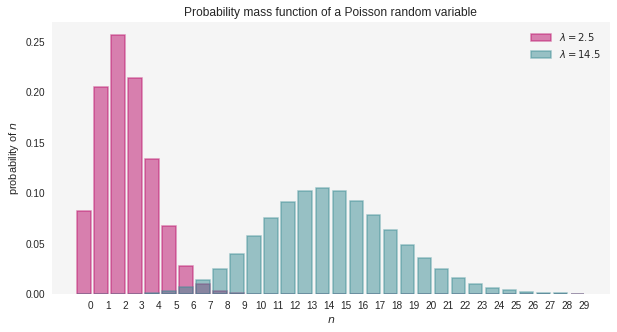

In [4]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor'] = '#F5F5F5'

figsize(10,5)

import scipy.stats as stats
a = np.arange(30)
poi = stats.poisson
lambdas = [2.5, 14.5]
colors = ["#ba0b68", "#3a8c94"]

# plot a Poisson distribution for each lambda
for lambda_, color in zip(lambdas, colors):
    plt.bar(a, poi.pmf(a, lambda_), color=color,
            label="$\lambda = %.1f$" % lambda_, alpha=0.50,
            edgecolor=color, lw=1.5)

plt.title("Probability mass function of a Poisson random variable")
plt.legend()
plt.grid()
plt.ylabel("probability of $n$")
plt.xticks(a + 0.4, a)
plt.xlabel("$n$")
plt.show()

The lower value of  **λ  = 2.5** would produce higher probabilities for lower medal counts (25% chance of winning 2 medals, but virtually no chance of winning 15 medals), whereas the higher  **λ  = 14.5 **would assign higher probabilities for higher medal counts (virtually no chance of winning 0 medals, but much greater chance of a medal count in the teens).

So what is  λ  for Norway's medal count? Well, from Norway's historical medal count plot, we observed that something changed in 1992, so we suspect that Norway's historical medal count is actually governed by two different values of  λ : the  λ1  pre-1992 olympics, and the  λ2  post-1992 olympics. In other words,

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$
where  τ  is the switchpoint. (we observe that  τ  appears to be the 1992 olympic games, but we're going to let the math prove it).

**Bayesian Inference**  
Bayesian inference attempts to derive posterior probabilities from prior probabilities and a likelihood function. We want to predict 2010 medal count probabilities from historical medal count probabilities and a model representing how likely the new probabilities are to occur.

We need to create:

*   prior probabilities of medal counts
*   a model (comprised of  τ ,  λ1 , and  λ2 ) that represents the likelihood of the posterior probabilities   
To do all this, we will install PyMC, a Python library for performing Bayesian analysis.

In [5]:
# installing PyMC
!pip install pymc

    100% |████████████████████████████████| 358kB 8.7MB/s 
  Running setup.py bdist_wheel for pymc ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/e4/6d/cf/3c408a39cf0f43e3b8abcace9758575f29c6aa860e17e9222d
Successfully built pymc


We will now create a model using the prior Norway medal counts.

In [0]:
import pymc as pm
import numpy as np

def make_model(data):
    '''
    Create a model for use in predicting lambda_1, lambda_2, and tau,
    which combine to create our posterior probability distributions
    (one before tau, and one after tau).
    '''
    # prior lambda estimates
    alpha = 1.0 / data.mean() 
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    # prior tau estimates
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(data))

    @pm.deterministic
    def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
        '''Create random value of lambda, based on prior lambda.'''
        out = np.zeros(len(data))
        out[:tau] = lambda_1  # lambda before tau
        out[tau:] = lambda_2  # lambda after (and including) tau
        return out
    
    # lambda is Poisson distributed
    observation = pm.Poisson("obs", lambda_, value=data.values, observed=True)

    model = pm.Model([observation, lambda_1, lambda_2, tau])
    return model

In [0]:
# using the custom function to create Bayesian model
model = make_model(nor_medals_year)

The next step is to use PyMC's Markov chain Monte Carlo (MCMC) object to sample thousands of random possibilities of  λ1 ,  λ2 , and  τ , and collect samples (also random) of posterior values of each.

In [8]:
mcmc = pm.MCMC(model)
mcmc.sample(50000, 10000, 1)

 [-----------------100%-----------------] 50000 of 50000 complete in 7.4 sec

The output of the PyMC MCMC algorithm is called a trace, which is the sequence of retained samples for each variable in the model. Here you extract the last set of samples for each variable.

In [0]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

We can now plot the samples to give us the posterior probabilities of λ1, λ2, τ.

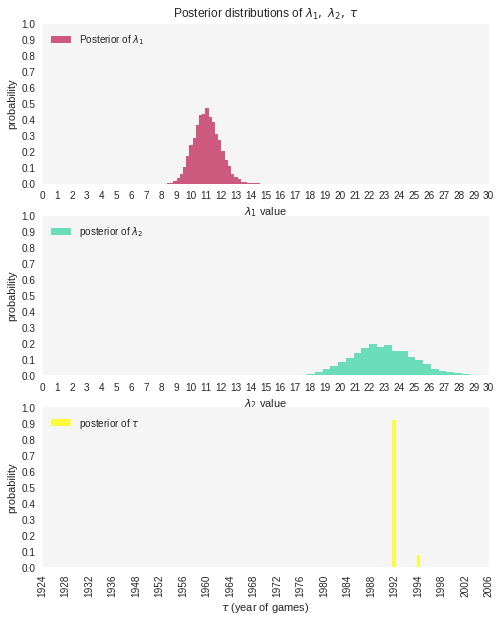

In [10]:
# our data
data = nor_medals_year
n_data = len(data)
years = data.index.values

figsize(8, 10)
xticks = np.arange(0, 31, 1)
yticks = np.arange(0.0, 1.1, 0.1)

# lambda_1
ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.65,
         label="Posterior of $\lambda_1$", color="#ba053e", normed=True)
plt.legend(loc="upper left")
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel("$\lambda_1$ value")
plt.ylabel("probability");
plt.title(r"""Posterior distributions of $\lambda_1,\;\lambda_2,\;\tau$""")
plt.grid()

# lambda_2
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.65,
         label="posterior of $\lambda_2$", color="#21d199", normed=True)
plt.legend(loc="upper left")
plt.xticks(xticks)
plt.xlim([xticks.min(), xticks.max()])
plt.yticks(yticks)
plt.xlabel("$\lambda_2$ value")
plt.ylabel("probability");
plt.grid()

# tau
ax = plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#fcfc3f", weights=w, rwidth=2.)
plt.legend(loc="upper left")
plt.xticks(np.arange(n_data), years, rotation='vertical')
plt.yticks(yticks)
plt.xlabel(r"$\tau$ (year of games)")
plt.ylabel("probability");
plt.grid()

**Results**  
The first plot shows  λ1  is about 11, and the probability that Norway wins 11 medals in the 1988 winter olympics would have been nearly 50%. Further, the distribution of this plot is narrow, meaning there was low uncertainty in getting a medal count outside of the 9 to 13 range. Unfortunately, if we based your prediction on these results, you would have been way off. 1988 was the first and only time Norway failed to win a gold medal in the winter olympics. Norway took home a mere 5 medals. (It is important to note that the Poisson distribution is infinite. That is, there was a probability, however small, of Norway winning 5 medals.)

In [11]:
nor_medals_year['1988']

5

How well  have we predicted the 2010 medal count? Looking at the second plot, the value of  λ2  is about 23. The uncertainty is greater, as indicated by the wider distribution, so the highest probability was about 20% (to win 23 medals). There was a combined probability of about 50% to win either 22, 23, or 24 medals. As it turns out, Norway won 23 medals in the 2010 winter olympics. Nice work!

What about  τ ? Our model validated  earlier observation that something changed in the winter olympic games starting in 1992. The third plot shows a greater than 90% chance of a change occurring that year. If there was no change, and  λ1  and  λ2 turned out to be similar, then the two distributions would have looked the same.